In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
hex_scheduled = _hex_json.loads("false")

In [ ]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [ ]:
hex_run_context = _hex_json.loads("\"logic\"")

In [ ]:
hex_timezone = _hex_json.loads("\"America/Denver\"")

In [ ]:
hex_project_id = _hex_json.loads("\"a56f4b22-0ae5-4939-ae32-943ccbe20f5e\"")

In [ ]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

### Data Connection
To work with the large-scale data in this project, I have landed the data in Snowflake. I am using Hex's Snowpark integration to leverage Snowflake's scalable compute for query operations.

In [ ]:
## Snowpark 
import snowflake.snowpark
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import col
from snowflake.snowpark.types import StringType, DateType, TimestampType, IntegerType, StructType, StructField, FloatType
from snowflake.snowpark.functions import dateadd, current_date
from snowflake.snowpark.functions import udtf

# Connection to Snowflake db
import hextoolkit
hex_snowflake_conn = hextoolkit.get_data_connection('CSPB 4502')
session = hex_snowflake_conn.get_snowpark_session()

### Queries
I ran queries against the tables in Snowflake. I created a restaurant_reviews dataframe that includes review data joined with restaurant data and the sentiment scores generated below.

In [ ]:
# import jinja2
# raw_query = """
#     select count(*) from PUBLIC.REVIEWS
# """
# sql_query = jinja2.Template(raw_query).render(vars())

In [ ]:
# import jinja2
# raw_query = """
#     SELECT r.*, b.*, s.SENTIMENT
#     FROM PUBLIC.REVIEWS r 
#     LEFT JOIN PUBLIC.BUSINESS b ON r.BUSINESS_ID = b.BUSINESS_ID
#     LEFT JOIN PUBLIC.SENTIMENTS s ON r.REVIEW_ID = s.REVIEW_ID
#     WHERE CONTAINS(CATEGORIES, 'Restaurants')
# """
# sql_query = jinja2.Template(raw_query).render(vars())

### Review Text Sentiment Analysis
I used the basic TextBlob pre-trained model to analyze the sentiment of the reviews. There are likely better models more fine-tuned for this task, but this one was simple to implement and behaves intuitively (i.e. stars are well correlated with sentiments). After generating the sentiment scores, which takes ~45 minutes, I wrote the results back to a table in Snowflake for future use.

In [ ]:
from textblob import TextBlob



def sentiment_analysis(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity


restaurant_reviews["sentiment"] = restaurant_reviews["REVIEW_TEXT"].apply(
    sentiment_analysis
)

In [ ]:
# if hex_run_context in []:
#     import hextoolkit
#     hex_data_connection = hextoolkit.get_data_connection("Snowflake")
#     writeback_metadata = hex_data_connection.write_dataframe(df=restaurant_reviews, database="PC_HEX_DB", schema="PUBLIC", table="review_sentiment", overwrite=True)

### Sentiment Analysis Review
You can filter and explore the reviews by state and city below by selecting data in the charts. This process will:

1. Display the reviewed restaurants on an interactive map
2. Display the review star ratings plotted against the sentiment analysis scores

In [ ]:
import altair
chart_restaurant_reviews = altair.Chart.from_json("""
{
    "width": 500,
    "height": 500,
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "layer": [
        {
            "resolve": {
                "scale": {
                    "color": "independent",
                    "y": "shared"
                }
            },
            "layer": [
                {
                    "transform": [],
                    "layer": [
                        {
                            "mark": {
                                "type": "bar",
                                "clip": true,
                                "filled": true
                            },
                            "params": [
                                {
                                    "name": "bar_intervalselection_",
                                    "select": {
                                        "type": "interval",
                                        "encodings": [
                                            "x"
                                        ],
                                        "mark": {
                                            "fill": "#669EFF",
                                            "fillOpacity": 0.07,
                                            "stroke": "#669EFF",
                                            "strokeOpacity": 0.4
                                        }
                                    }
                                },
                                {
                                    "name": "click_pointselection_",
                                    "select": {
                                        "type": "point",
                                        "encodings": [
                                            "x"
                                        ]
                                    },
                                    "value": [
                                        {
                                            "STATE": "CA"
                                        }
                                    ]
                                }
                            ],
                            "encoding": {
                                "opacity": {
                                    "condition": {
                                        "test": {
                                            "not": {
                                                "and": [
                                                    {
                                                        "param": "click_pointselection_"
                                                    }
                                                ]
                                            },
                                            "empty": false
                                        },
                                        "value": 0.3
                                    },
                                    "value": 1
                                },
                                "tooltip": [
                                    {
                                        "field": "STATE",
                                        "type": "ordinal"
                                    },
                                    {
                                        "field": "REVIEW_ID",
                                        "type": "quantitative",
                                        "aggregate": "count",
                                        "title": "Count of Records"
                                    }
                                ]
                            }
                        }
                    ],
                    "encoding": {
                        "x": {
                            "field": "STATE",
                            "type": "ordinal",
                            "title": "STATE",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            },
                            "sort": "-y"
                        },
                        "y": {
                            "field": "REVIEW_ID",
                            "type": "quantitative",
                            "aggregate": "count",
                            "title": "Count of Records",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "color": {
                            "value": "#4C78A8"
                        }
                    }
                },
                {
                    "transform": [
                        {
                            "aggregate": [],
                            "groupby": [
                                "STATE"
                            ]
                        },
                        {
                            "window": [
                                {
                                    "op": "rank",
                                    "as": "rank"
                                }
                            ]
                        },
                        {
                            "filter": "datum.rank <= 21"
                        }
                    ],
                    "mark": {
                        "type": "rule",
                        "clip": true
                    },
                    "name": "aggregate_xAxis_spec_64633cb0_3b21_4b66_b711_d4150cfdb880",
                    "encoding": {
                        "opacity": {
                            "value": 0
                        }
                    }
                },
                {
                    "name": "__drilldown_dataset",
                    "mark": {
                        "type": "point",
                        "opacity": 0
                    },
                    "transform": [
                        {
                            "filter": {
                                "param": "click_pointselection_"
                            }
                        }
                    ]
                }
            ]
        }
    ],
    "resolve": {
        "scale": {}
    },
    "datasets": {
        "layer00": [
            {
                "name": "dummy",
                "value": 0
            }
        ]
    },
    "config": {
        "legend": {
            "orient": "right"
        }
    },
    "usermeta": {
        "selectionConfigs": {
            "bar_intervalselection_": {
                "type": "interval",
                "datetimeFields": []
            },
            "click_pointselection_": {
                "type": "point",
                "datetimeFields": []
            }
        }
    }
}
""")
chart_restaurant_reviews.datasets.layer00 = restaurant_reviews.to_json(orient='records')
chart_restaurant_reviews.display(actions=False)

In [ ]:
import altair
chart_filtered_state = altair.Chart.from_json("""
{
    "width": 500,
    "height": 500,
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "layer": [
        {
            "resolve": {
                "scale": {
                    "color": "independent",
                    "y": "shared"
                }
            },
            "layer": [
                {
                    "transform": [],
                    "layer": [
                        {
                            "mark": {
                                "type": "bar",
                                "clip": true,
                                "filled": true
                            },
                            "params": [
                                {
                                    "name": "bar_intervalselection_",
                                    "select": {
                                        "type": "interval",
                                        "encodings": [
                                            "x"
                                        ],
                                        "mark": {
                                            "fill": "#669EFF",
                                            "fillOpacity": 0.07,
                                            "stroke": "#669EFF",
                                            "strokeOpacity": 0.4
                                        }
                                    }
                                },
                                {
                                    "name": "click_pointselection_",
                                    "select": {
                                        "type": "point",
                                        "encodings": [
                                            "x"
                                        ]
                                    },
                                    "value": [
                                        {
                                            "CITY": "Carpinteria"
                                        }
                                    ]
                                }
                            ],
                            "encoding": {
                                "opacity": {
                                    "condition": {
                                        "test": {
                                            "not": {
                                                "and": [
                                                    {
                                                        "param": "click_pointselection_"
                                                    }
                                                ]
                                            },
                                            "empty": false
                                        },
                                        "value": 0.3
                                    },
                                    "value": 1
                                },
                                "tooltip": [
                                    {
                                        "field": "CITY",
                                        "type": "ordinal"
                                    },
                                    {
                                        "field": "REVIEW_ID",
                                        "type": "quantitative",
                                        "aggregate": "count",
                                        "title": "Count of Records"
                                    }
                                ]
                            }
                        }
                    ],
                    "encoding": {
                        "x": {
                            "field": "CITY",
                            "type": "ordinal",
                            "title": "CITY",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            },
                            "sort": "-y"
                        },
                        "y": {
                            "field": "REVIEW_ID",
                            "type": "quantitative",
                            "aggregate": "count",
                            "title": "Count of Records",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "color": {
                            "value": "#4C78A8"
                        }
                    }
                },
                {
                    "transform": [
                        {
                            "aggregate": [],
                            "groupby": [
                                "CITY"
                            ]
                        },
                        {
                            "window": [
                                {
                                    "op": "rank",
                                    "as": "rank"
                                }
                            ]
                        },
                        {
                            "filter": "datum.rank <= 21"
                        }
                    ],
                    "mark": {
                        "type": "rule",
                        "clip": true
                    },
                    "name": "aggregate_xAxis_spec_68586652_75eb_46e1_a07e_2c8e1a578506",
                    "encoding": {
                        "opacity": {
                            "value": 0
                        }
                    }
                },
                {
                    "name": "__drilldown_dataset",
                    "mark": {
                        "type": "point",
                        "opacity": 0
                    },
                    "transform": [
                        {
                            "filter": {
                                "param": "click_pointselection_"
                            }
                        }
                    ]
                }
            ]
        }
    ],
    "resolve": {
        "scale": {}
    },
    "datasets": {
        "layer00": [
            {
                "name": "dummy",
                "value": 0
            }
        ]
    },
    "config": {
        "legend": {
            "orient": "right"
        }
    },
    "usermeta": {
        "selectionConfigs": {
            "bar_intervalselection_": {
                "type": "interval",
                "datetimeFields": []
            },
            "click_pointselection_": {
                "type": "point",
                "datetimeFields": []
            }
        }
    }
}
""")
chart_filtered_state.datasets.layer00 = filtered_state.to_json(orient='records')
chart_filtered_state.display(actions=False)

In [ ]:
import altair
chart_filtered_city = altair.Chart.from_json("""
{
    "width": 500,
    "height": 500,
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "layer": [
        {
            "resolve": {
                "scale": {
                    "color": "independent",
                    "y": "shared"
                }
            },
            "layer": [
                {
                    "transform": [
                        {
                            "filter": "isValid(datum[\"REVIEWS\\.STARS\"])"
                        }
                    ],
                    "layer": [
                        {
                            "mark": {
                                "type": "point",
                                "filled": false,
                                "clip": true
                            }
                        }
                    ],
                    "encoding": {
                        "x": {
                            "field": "REVIEWS\\.STARS",
                            "type": "quantitative",
                            "title": "REVIEWS.STARS",
                            "scale": {
                                "padding": 8
                            },
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "y": {
                            "field": "SENTIMENT",
                            "type": "quantitative",
                            "aggregate": "average",
                            "title": "Average of SENTIMENT",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "color": {
                            "value": "#4C78A8"
                        },
                        "opacity": {
                            "value": 1
                        }
                    }
                },
                {
                    "mark": {
                        "type": "point",
                        "filled": false,
                        "clip": true
                    },
                    "encoding": {
                        "x": {
                            "field": "REVIEWS\\.STARS",
                            "type": "quantitative",
                            "title": "REVIEWS.STARS",
                            "scale": {
                                "padding": 8
                            },
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "y": {
                            "field": "SENTIMENT",
                            "type": "quantitative",
                            "aggregate": "average",
                            "title": "Average of SENTIMENT",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "color": {
                            "value": "#4C78A8"
                        },
                        "tooltip": [
                            {
                                "field": "REVIEWS\\.STARS",
                                "type": "quantitative"
                            },
                            {
                                "field": "SENTIMENT",
                                "type": "quantitative",
                                "aggregate": "average",
                                "title": "Average of SENTIMENT"
                            }
                        ],
                        "opacity": {
                            "value": 0,
                            "condition": {
                                "param": "point_hover_bbe54a28-3f47-4ca0-ac33-6316279c3229",
                                "value": 1,
                                "empty": false
                            }
                        },
                        "size": {
                            "value": 100
                        }
                    },
                    "params": [
                        {
                            "name": "point_hover_bbe54a28-3f47-4ca0-ac33-6316279c3229",
                            "select": {
                                "type": "point",
                                "on": "mouseover",
                                "nearest": false
                            }
                        }
                    ]
                }
            ]
        }
    ],
    "resolve": {
        "scale": {}
    },
    "datasets": {
        "layer00": [
            {
                "name": "dummy",
                "value": 0
            }
        ]
    },
    "config": {
        "legend": {
            "orient": "right"
        }
    },
    "usermeta": {
        "selectionConfigs": {}
    }
}
""")
chart_filtered_city.datasets.layer00 = filtered_city.to_json(orient='records')
chart_filtered_city.display(actions=False)

### K-Means Clustering of Restaurant Reviewers
Below I have conducted K-Means clustering of reviewers who reviewed restaurants. I evaluated SSE against number of clusters and determined that three clusters was sufficient.

After completing the clustering, I created a 2D PCA to plot the clusters of restaurant reviewers.

In [ ]:
# import jinja2
# raw_query = """
#     SELECT *
#     FROM PUBLIC.USERS
#     WHERE USER_ID IN (
#         SELECT DISTINCT r.USER_ID
#         FROM PUBLIC.REVIEWS r
#         INNER JOIN PUBLIC.BUSINESS b
#         ON r.BUSINESS_ID = b.BUSINESS_ID
#     );
# """
# sql_query = jinja2.Template(raw_query).render(vars())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_kmeans = restaurant_reviewers.drop(["USER_ID", "NAME"], axis=1)

# Extracting year from 'YELPING_SINCE' column
df_kmeans['YELPING_SINCE'] = pd.to_datetime(df['YELPING_SINCE']).dt.year

# Scaling features
scaler = StandardScaler()
scaled_df_kmeans = scaler.fit_transform(df_kmeans)


In [ ]:
import matplotlib.pyplot as plt
# determine ideal number of clusters

# use sampled data to speed up clustering
df_kmeans_sample = df_kmeans.sample(n=100000)
scaled_df_kmeans_sample = scaler.fit_transform(df_kmeans_sample)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 406,
}

sse = [] # list containing sum of squared error for each cluster iteration
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df_kmeans_sample)
    sse.append(kmeans.inertia_)


elbow_data = list(zip(range(1,11), sse))
elbow_df = pd.DataFrame(elbow_data, columns=['n_clusters', 'sse'])

In [ ]:
import altair
chart_elbow_df = altair.Chart.from_json("""
{
    "width": 500,
    "height": 500,
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "layer": [
        {
            "resolve": {
                "scale": {
                    "color": "independent",
                    "y": "shared"
                }
            },
            "layer": [
                {
                    "transform": [
                        {
                            "filter": "isValid(datum[\"n_clusters\"])"
                        }
                    ],
                    "layer": [
                        {
                            "mark": {
                                "type": "line",
                                "point": false,
                                "clip": true
                            },
                            "encoding": {
                                "opacity": {
                                    "value": 1
                                }
                            }
                        },
                        {
                            "mark": {
                                "type": "point",
                                "clip": true
                            },
                            "encoding": {
                                "opacity": {
                                    "value": 0,
                                    "condition": {
                                        "param": "pivot_hover_b72a38dd-baf9-4a27-98d3-17930c49cb17",
                                        "value": 1,
                                        "empty": false
                                    }
                                },
                                "size": {
                                    "value": 80
                                }
                            }
                        },
                        {
                            "mark": {
                                "type": "rule",
                                "clip": true
                            },
                            "encoding": {
                                "opacity": {
                                    "condition": {
                                        "value": 0.3,
                                        "param": "pivot_hover_b72a38dd-baf9-4a27-98d3-17930c49cb17",
                                        "empty": false
                                    },
                                    "value": 0
                                },
                                "color": {
                                    "value": "CHART_DEFAULT_RULE_COLOR_MARKER"
                                },
                                "tooltip": [
                                    {
                                        "field": "n_clusters",
                                        "type": "quantitative"
                                    },
                                    {
                                        "field": "sse",
                                        "type": "quantitative",
                                        "aggregate": "sum",
                                        "title": "Sum of sse"
                                    }
                                ],
                                "y": null
                            },
                            "params": [
                                {
                                    "name": "pivot_hover_b72a38dd-baf9-4a27-98d3-17930c49cb17",
                                    "select": {
                                        "type": "point",
                                        "fields": [
                                            "n_clusters"
                                        ],
                                        "nearest": true,
                                        "on": "mouseover",
                                        "clear": "mouseout"
                                    }
                                }
                            ]
                        }
                    ],
                    "encoding": {
                        "x": {
                            "field": "n_clusters",
                            "type": "quantitative",
                            "title": "n_clusters",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "y": {
                            "field": "sse",
                            "type": "quantitative",
                            "aggregate": "sum",
                            "title": "Sum of sse",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "color": {
                            "value": "#4C78A8"
                        }
                    }
                }
            ]
        }
    ],
    "resolve": {
        "scale": {}
    },
    "datasets": {
        "layer00": [
            {
                "name": "dummy",
                "value": 0
            }
        ]
    },
    "config": {
        "legend": {
            "orient": "right"
        }
    },
    "usermeta": {
        "selectionConfigs": {}
    }
}
""")
chart_elbow_df.datasets.layer00 = elbow_df.to_json(orient='records')
chart_elbow_df.display(actions=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



# Perform K-means clustering (let's assume the number of clusters is 5)
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df_kmeans)

# Add cluster labels to the original DataFrame
restaurant_reviewers['cluster'] = kmeans.labels_






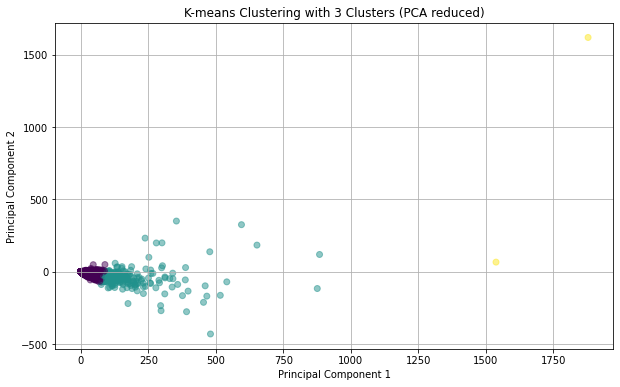

In [ ]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df_kmeans)

# Create a scatter plot with the PCA results and color by cluster
plt.figure(figsize=(10, 6), facecolor='white')
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=restaurant_reviewers['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with 3 Clusters (PCA reduced)')

# Add gridlines
plt.grid(True)

# Set the background color to white
plt.gca().set_facecolor('white')

# Show the plot
plt.show()

In [ ]:
# Create a new DataFrame from the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['Principal Component 1', 'Principal Component 2'])

# Add the cluster labels to the new DataFrame
pca_df['Cluster'] = restaurant_reviewers['cluster'].values

In [ ]:
import altair
chart_pca_df = altair.Chart.from_json("""
{
    "width": 500,
    "height": 500,
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "layer": [
        {
            "resolve": {
                "scale": {
                    "color": "independent",
                    "y": "shared"
                }
            },
            "layer": [
                {
                    "transform": [
                        {
                            "filter": "isValid(datum[\"Principal Component 1\"])"
                        }
                    ],
                    "layer": [
                        {
                            "mark": {
                                "type": "point",
                                "filled": true,
                                "clip": true
                            }
                        }
                    ],
                    "encoding": {
                        "x": {
                            "field": "Principal Component 1",
                            "type": "quantitative",
                            "title": "Principal Component 1",
                            "scale": {
                                "domainMin": 0,
                                "domainMax": 2000,
                                "padding": 8
                            },
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            },
                            "sort": "descending"
                        },
                        "y": {
                            "field": "Principal Component 2",
                            "type": "quantitative",
                            "title": "Principal Component 2",
                            "scale": {
                                "domainMin": -500,
                                "domainMax": 2000
                            },
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "color": {
                            "field": "Cluster",
                            "type": "quantitative",
                            "title": "Cluster"
                        },
                        "opacity": {
                            "value": 1
                        }
                    }
                },
                {
                    "mark": {
                        "type": "point",
                        "filled": true,
                        "clip": true
                    },
                    "encoding": {
                        "x": {
                            "field": "Principal Component 1",
                            "type": "quantitative",
                            "title": "Principal Component 1",
                            "scale": {
                                "domainMin": 0,
                                "domainMax": 2000,
                                "padding": 8
                            },
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            },
                            "sort": "descending"
                        },
                        "y": {
                            "field": "Principal Component 2",
                            "type": "quantitative",
                            "title": "Principal Component 2",
                            "scale": {
                                "domainMin": -500,
                                "domainMax": 2000
                            },
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "color": {
                            "field": "Cluster",
                            "type": "quantitative",
                            "title": "Cluster",
                            "legend": null
                        },
                        "tooltip": [
                            {
                                "field": "Principal Component 1",
                                "type": "quantitative"
                            },
                            {
                                "field": "Principal Component 2",
                                "type": "quantitative",
                                "title": "Principal Component 2"
                            },
                            {
                                "field": "Cluster",
                                "type": "quantitative"
                            }
                        ],
                        "opacity": {
                            "value": 0,
                            "condition": {
                                "param": "point_hover_bdd4ddbc-6cfc-4b84-958c-69f99734ee65",
                                "value": 1,
                                "empty": false
                            }
                        },
                        "size": {
                            "value": 100
                        }
                    },
                    "params": [
                        {
                            "name": "point_hover_bdd4ddbc-6cfc-4b84-958c-69f99734ee65",
                            "select": {
                                "type": "point",
                                "on": "mouseover",
                                "nearest": false
                            }
                        }
                    ]
                }
            ]
        }
    ],
    "resolve": {
        "scale": {}
    },
    "datasets": {
        "layer00": [
            {
                "name": "dummy",
                "value": 0
            }
        ]
    },
    "config": {
        "legend": {
            "orient": "right"
        }
    },
    "usermeta": {
        "selectionConfigs": {}
    }
}
""")
chart_pca_df.datasets.layer00 = pca_df.to_json(orient='records')
chart_pca_df.display(actions=False)